# Data analysis SICLOPSS NGS

### Imports

In [30]:
import statistics
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans 
from sklearn.manifold import TSNE
from collections import Counter
from Bio import SeqIO
from Bio.Seq import Seq
from datetime import datetime

import xlsxwriter
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches 
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.patches import Rectangle

### Set the input files


In [12]:
datapath = 'C:/Users/lmwin/Desktop/Data/'

cp0=datapath+'pan-0_S1_L001_R1_001.fastq'
cp1=datapath+'pan-1_S2_L001_R1_001.fastq'
cp2=datapath+'pan-2_S3_L001_R1_001.fastq'

out='C:/Users/lmwin/Desktop/'

# data to be processed
# [prefix, name. path_to_data]
tasks=[['0','Pan 0',cp0],['A','Pan 1',cp1],['B','Pan 2',cp2]]

### Functions to process the sequencing data

In [154]:
def mc2(sequences,name,out):
    """
    Function mc creates a text file with two tabs to process a counter.
    The left one contains the sequences.
    The right one says how many times this sequence is present in the respective Run.
    """
    Seqcount=Counter(sequences)
    mclist=Seqcount.most_common()
    writer=open('%s-%s-mc.txt'%(out,name),'w')
    writer2=open('%s-%s-over50.txt'%(out,name),'w')
    for dna in mclist:
        writer.write('{} {}\n'.format(dna[0],dna[1]))
        if dna[1]>50:
            for i in range(dna[1]):
                writer2.write('{}\n'.format(dna[0]))
    writer.close()    
    return(mclist,Seqcount)

def text(sequences,name,out):
    """
    Function text creates a simple textfile where one sequence is written below the other.
    """   
    writer=open('%s-%s.txt'%(out,name),'w')
    for i in sequences:
        writer.write('{}\n'.format(i))
    writer.close()

def baseplotter(basecount,folder,dataset,run,name,length): 
    bases=['T','C','A','G']
    x=np.arange(1,length+1)
    colors=['red','blue','green','black']
    plt.axhline(y=50,color='dimgray',linewidth=0.5)
    plt.axhline(y=25,color='dimgray',linewidth=0.5)
    plt.axhline(y=75,color='dimgray',linewidth=0.5)
    for i in range(4):
         plt.scatter(x=x, y=basecount[:,i], label=bases[i] , color= colors[i],  
                     marker='.', s=30)    
    # x-axis label
    plt.xlabel('position') 
    plt.xticks(np.arange(1,length+1,1))
    # frequency label 
    plt.ylabel('% base') 
    plt.yticks(np.arange(0,101,10))
    # plot title 
    plt.title('run %s%s'%(run,name)) 
# showing legend 
    plt.legend(loc='upper right')
    plt.savefig("%s%s-%s-bases%s.pdf" %(folder,dataset,run,name))
# function to show the plot 
    plt.show()
    
def baseplot(sequences,folder,dataset,run,name):
    """
    Function baseplot calculates the amout of each base for the extein-coding region.
    The output is a pdf with all the bases (to compare to expectations from Sanger)
    """
    bases=['T','C','A','G']
    length=18
    basecount=np.zeros((length,4))
    for sequence in sequences:
        for b in range(length):
            base=sequence[b]
            for i in [i for i,x in enumerate(bases) if x==base]:
                basecount[b][i]+=1
    np.save('%s%s-%s-bases_data.npy'%(folder,dataset,run),basecount)
    for i in range(length):
        basecount[i,:]*=100/sum(basecount[i,:])
    baseplotter(basecount,folder,dataset,run,name,length)
    
def counting(mclist,name):
    numbers=[] #gets the occurences of sequences
    for items in mclist:
        numbers.append(items[1]) 
    numcount=Counter(numbers)
    mcnumcount=numcount.most_common()  
    x1=[]
    y1=[]
    for num in mcnumcount:
        x1.append(num[0])
        y1.append(num[1])
    return([x1,y1,name])
    
    
def writefiles(dataset,run,folder,clusters):
    """
    Function writefiles generates all initial files for individual sequencing runs.
    It starts with a list of DNA sequences and gives out text files in folders for 
    DNA and amino acids.
    """    
    NOsequences=len(clusters)
    outfolderDNA=folder+'DNA/'
    outfolderAA=folder+'AA/'
    outDNA=folder+'DNA/'+dataset+'-'+run
    outAA=folder+'AA/'+dataset+'-'+run
    if not os.path.exists(outfolderDNA):
        os.makedirs(outfolderDNA)
    if not os.path.exists(outfolderAA):
        os.makedirs(outfolderAA)
    print (datetime.now())
    
    #find the splice junction
    postNheI='CTAGCCAATGGGGCGATCGCCCACAAT'#sequence after NheI restriction site
    start=33
    NX5=[s[start+27:] for s in clusters if s[start:start+27]==postNheI]

    cx=[Seq(s) for s in NX5 if Seq(s[:3]).translate().startswith('C')]
    cx5=[s[:18] for s in cx] 

    #moving on to peptides            
    CX=[s.translate() for s in cx] #translate everything after splicejunction
    CX5=[s[:6] for s in CX if s[6:16]=='CLSFGTEILT'] # check for correct amino acids post CX5
    cCX5=[str(s) for s in CX5 if '*' not in str(s)] # check for stop codons in CX5
    #save lists into textfiles text files
    text(NX5,'NX5',outDNA)
    text(CX5,'CX5',outAA)
    text(cCX5,'cCX5',outAA)
    #count how many times a sequence occurs
    DNAmc,DNACount=mc2(clusters,'DNA',outDNA)
    CX5mc,CX5Count=mc2(CX5,'CX5',outAA)
    cCX5mc,cCX5Count=mc2(cCX5,'cCX5',outAA) 
    #plot the extein coding dna into a baseplot
    baseplot(cx5,folder,dataset,run,'') 
    #document the results in a summary file

    
    #write it all into an excel sheet    
    workbook=xlsxwriter.Workbook("%s%s-%s-Stats.xlsx" %(folder,dataset,run))  
    worksheet=workbook.add_worksheet('summary')
    worksheet.set_column('A:A', 30)
    worksheet.set_column('B:B',13)
    bold = workbook.add_format({'bold': True})
    million=workbook.add_format({'num_format': '#,###'})
    dec=workbook.add_format({'num_format':'#0.00'})
    #worksheet.write(0,0,keys[dataset][0])
    worksheet.write(0,1,'Run %s'%run,bold)
    worksheet.write(1,0,'Total clusters pf')
    worksheet.write(2,0,'Total NX5 (contain splice junction)')
    worksheet.write(1,1,NOsequences,million)
    worksheet.write(2,1,len(NX5),million)
    worksheet.write(6,0,'Total cCX5')
    worksheet.write(7,0,'Unique cCX5')
    worksheet.write(8,0,'theoretical coverage cCX5')
    worksheet.write(6,1,len(cCX5),million)
    worksheet.write(7,1,len(cCX5Count),million)
    worksheet.write(8,1,len(cCX5)/len(cCX5Count),dec)
    worksheet.write(10,0,'Total CX5')
    worksheet.write(11,0,'Unique CX5')
    worksheet.write(12,0,'average coverage CX5')
    worksheet.write(10,1,len(CX5),million)
    worksheet.write(11,1,len(CX5Count),million)
    worksheet.write(12,1,len(CX5)/len(CX5Count),dec)
    workbook.close()
    return (cCX5mc,cCX5Count)


def sequence_boxes(cx5, per=500000, out = "", name=""):

    cx5_c = Counter(cx5)
    cx5_sum = sum(cx5_c.values())
    cx5_mc =cx5_c.most_common()
    print(sum(cx5_c.values()))
    
    # define the borders
    # lowest is 1 per 100 K sequences
    borders = [100000, 10000, 1000, 100, 10, 0]
    
    # define the top ten sequences and assign them to borders
    top10= []
    top10_value = 0
    # generate empty lists for each group
    sequences_in_borders = [[] for i in range(len(borders))]
    values_in_borders = [0]*len(borders)
    border = 0
    for sequence, copy_number in cx5_mc:
        if copy_number/cx5_sum*per > borders[border]:
            sequences_in_borders[border].append((sequence))
            values_in_borders[border]+= copy_number/cx5_sum
            if top10_value <=10:
                top10.append(border)
                top10_value+=1

        elif copy_number/cx5_sum*per > borders[border+1]:
            print(sequence)
            border+=1
            sequences_in_borders[border].append((sequence))
            values_in_borders[border]+= copy_number/cx5_sum
            if top10_value <=10:
                top10.append(border)
                top10_value+=1

        elif copy_number/cx5_sum*per > borders[border+2]:
            print(sequence,'ok')
            border+=2
            sequences_in_borders[border].append((sequence))
            values_in_borders[border]+= copy_number/cx5_sum
            if top10_value <=10:
                top10.append(border)
                top10_value+=1
        else: print(sequence, 'wtf')
        
    # find the values for the boxes in borders (unique sequences)
    xvalues_in_borders = [len(i) for i in sequences_in_borders]
    
    # for the plot, organise the values from small to big
    sequences_in_borders= sequences_in_borders[::-1]
    values_in_borders = values_in_borders[::-1]
    xvalues_in_borders = xvalues_in_borders[::-1]
    
    # set the colors for the boxes
    colors = ['gray','darkkhaki','goldenrod','darkorange','red','maroon']
    
    # generate a plot with two subplots
    fig, axs = plt.subplots(nrows=1, ncols = 2,figsize=(5,4))
    # fil the first plot with data (ax is the first of the axs)
    ax=axs[0]
    ax.plot()
    # start with the y value as 0
    y = 0
    boxes=[]
    for i in range(len(borders)):
        # x, y, width, height
        box = ax.add_patch(Rectangle((0, y), xvalues_in_borders[i], values_in_borders[i], color = colors[i], ec='k'))
        boxes.append(box)
        # increase the y value so the boxes get stacked
        print(f"border:{i}, height: {y:.2f}, contribution[%]: {values_in_borders[i]*100:.2f}, Number of unique S: {xvalues_in_borders[i]}, color: {colors[i]}")
        y += values_in_borders[i]

    # hide the box on the right side and top
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    # scale the x axis
    ax.set_xscale('log')
    ax.set_ylim([0,1])
    ax.set_ylabel('Fraction of Total Sequences')
    ax.set_xlabel('# of Unique Sequences')
    #ax.set_title(title)
    
    #plot the legend to the second subplot to have more space
    axs[1].legend(handles = boxes[::-1],
              labels = ['>10⁵','10⁴-10⁵','10³-10⁴','10²-10³','10¹-10²','1-10'],
              title = f'Sequence\nAbundance\nper {per:,}',
              loc='center left',bbox_to_anchor=(1, 0.5))
    
    #write some text
    axs[1].text(0, 1.05, "Sequence", size=12)
    axs[1].text(0.72, 1.05, "#", size=12)
    for i in range(11):
        seq = cx5_mc[i][0]
        #copy_n = '     {:6}'.format(int(cx5_mc[i][1]/cx5_sum*per))
        copy_n = f'     {(int(cx5_mc[i][1]/cx5_sum*per)):>7,}'
        #print(seq)
        axs[1].text(0.08, 1-0.08-i/12,seq)
        axs[1].text(0.5, 1-0.08-i/12,copy_n)
        # find in which group the sequence is
        box = axs[1].add_patch(Rectangle((0.01, 1-0.11-i/12), 0.05, 0.08, color = colors[::-1][top10[i]]))
    # hide the box for all of subplot 2
    axs[1].set_axis_off()
    plt.savefig(f"{out}/{name}_enrichment.png", dpi = 400)
    plt.show()

### Open and filter fastq files

2024-05-13 13:06:35.967285
clusters loaded
2024-05-13 13:07:01.576216


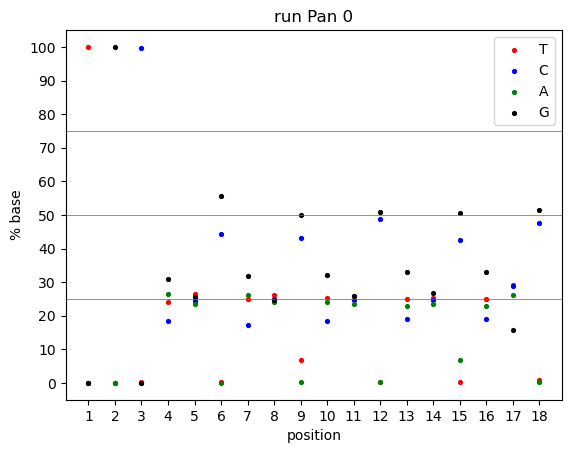

2024-05-13 13:08:48.174324
clusters loaded
2024-05-13 13:09:58.530017


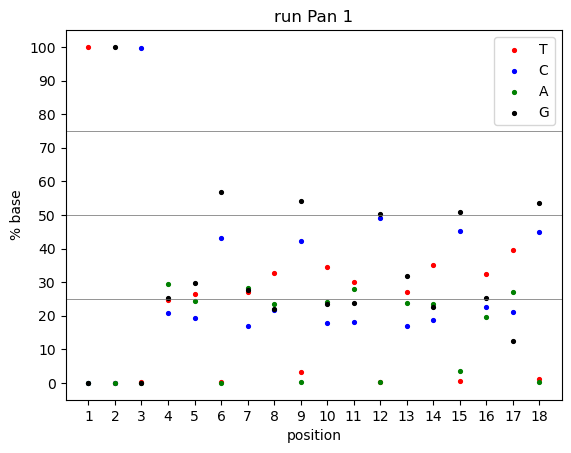

2024-05-13 13:56:17.134776
clusters loaded
2024-05-13 13:58:31.704855


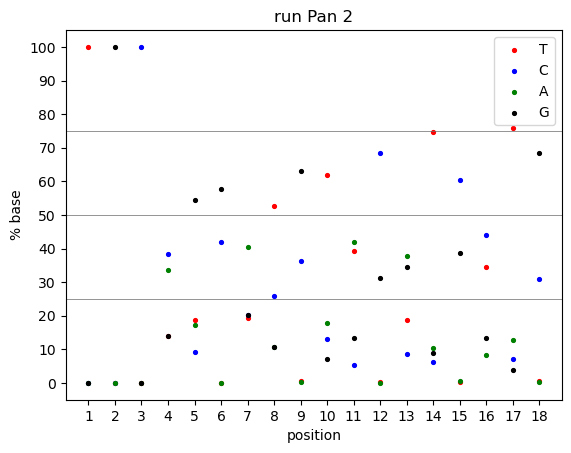

In [52]:
results_mc = []
results_c = []
for i in tasks:
        fastq=i[2]
        dataset=i[0] #abbreviation
        run=i[1] # title
        outfolder='%s01Analysis/Run-%s/'%(out,run) # outfolder defined at top
        if not os.path.exists(outfolder):
            os.makedirs(outfolder)
        print (datetime.now())
        # filter for sequences with average QCover 30
        clusters=[str(rec.seq) for rec in SeqIO.parse("%s"%(fastq), "fastq") if sum(rec.letter_annotations['phred_quality'])/len(rec)>=30]
        #clusters=clusters[:1000]
        print('clusters loaded')
        # generate analysis files
        cCX5mc,cCX5Count=writefiles(dataset,run,outfolder,clusters)
        results_mc.append(cCX5mc)
        results_c.append(cCX5Count)

In [54]:
plotdata0=counting(results_mc[0], 'initial library')
plotdata1=counting(results_mc[1], 'pan A')
plotdata2=counting(results_mc[2], 'pan B')

### plot the enrichment (within)

988076
CAAAAA
CRCVHS ok
CGRREV
CGACRS
border:0, height: 0.00, contribution[%]: 67.26, Number of unique S: 256149, color: gray
border:1, height: 0.67, contribution[%]: 22.91, Number of unique S: 12966, color: darkkhaki
border:2, height: 0.90, contribution[%]: 1.81, Number of unique S: 134, color: goldenrod
border:3, height: 0.92, contribution[%]: 0.00, Number of unique S: 0, color: darkorange
border:4, height: 0.92, contribution[%]: 8.01, Number of unique S: 1, color: red
border:5, height: 1.00, contribution[%]: 0.00, Number of unique S: 0, color: maroon


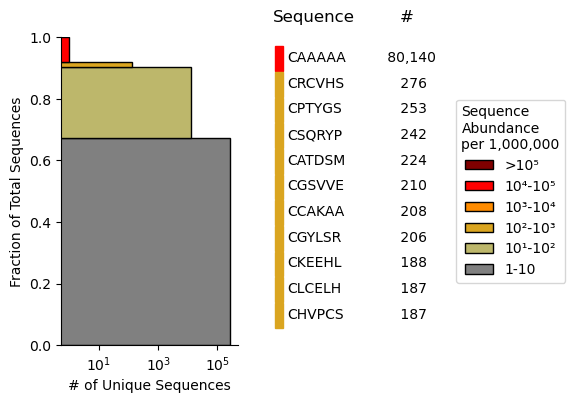

1632704
CAAAAA
CRTYIL
CGLIGG
CLALYG
CPFKGT
border:0, height: 0.00, contribution[%]: 48.18, Number of unique S: 260333, color: gray
border:1, height: 0.48, contribution[%]: 18.87, Number of unique S: 8261, color: darkkhaki
border:2, height: 0.67, contribution[%]: 14.36, Number of unique S: 549, color: goldenrod
border:3, height: 0.81, contribution[%]: 10.84, Number of unique S: 47, color: darkorange
border:4, height: 0.92, contribution[%]: 7.76, Number of unique S: 3, color: red
border:5, height: 1.00, contribution[%]: 0.00, Number of unique S: 0, color: maroon


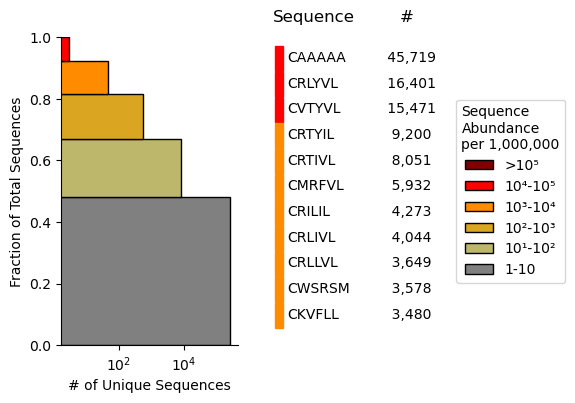

3167920
CRLYVL
CRRIIL
CVVITL
CKIWLL
CVQSCL
border:0, height: 0.00, contribution[%]: 9.11, Number of unique S: 119490, color: gray
border:1, height: 0.09, contribution[%]: 5.51, Number of unique S: 1962, color: darkkhaki
border:2, height: 0.15, contribution[%]: 9.61, Number of unique S: 343, color: goldenrod
border:3, height: 0.24, contribution[%]: 25.86, Number of unique S: 87, color: darkorange
border:4, height: 0.50, contribution[%]: 33.99, Number of unique S: 13, color: red
border:5, height: 0.84, contribution[%]: 15.91, Number of unique S: 1, color: maroon


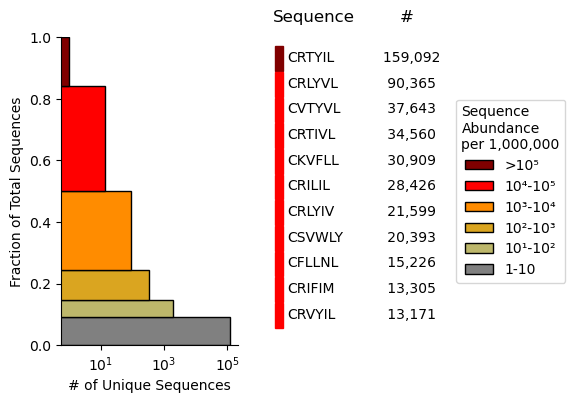

In [155]:
for name, pan in zip(["0", "1", "2"], ["0", "A", "B"]):
    f = open(f"{out}01Analysis/Run-Pan {name}/AA/{pan}-Pan {name}-cCX5.txt", "r")
    cx5 = f.readlines()
    cx5 = [i[:6] for i in cx5]
    f.close()
    sequence_boxes(cx5, per = 1000000, name = f"pan {pan}", out = f"{out}01Analysis")


### Write excel sheet to compare the pans

In [115]:
df = pd.concat([pd.Series(c) for c in results_c], axis = 1)
print(df)

            0      1     2
CLSSGI    1.0    2.0   NaN
CASLAM    8.0    6.0   3.0
CLNGWI    2.0    NaN   NaN
CAFACQ    4.0    NaN   NaN
CGRLGL  165.0  207.0  31.0
...       ...    ...   ...
CGVFMM    NaN    NaN   1.0
CKNLFC    NaN    NaN   1.0
CTFQKL    NaN    NaN   1.0
CSLFLF    NaN    NaN   1.0
CVHLHT    NaN    NaN   1.0

[367095 rows x 3 columns]


In [116]:
df.columns  = ["initial", "pan 1", "pan 2"]

In [117]:
df["sequence"]= df.index
df["initial [%]"] = df["initial"]/sum(results_c[0].values())
df["pan 1 [%]"] = df["pan 1"]/sum(results_c[1].values())
df["pan 2 [%]"] = df["pan 2"]/sum(results_c[2].values())

In [122]:
df = df.sort_values(by = "pan 2", ascending = False)
df = df.set_index(np.arange(1, len(df["sequence"].values)+1, 1))

In [123]:
df.to_csv(f"{out}01Analysis/df.csv")
df.head()

,initial,pan 1,pan 2,sequence,initial [%],pan 1 [%],pan 2 [%]
1,36.0,15021.0,503993.0,CRTYIL,0.000036,0.009200,0.159093
2,38.0,26779.0,286271.0,CRLYVL,0.000038,0.016402,0.090366
3,38.0,25260.0,119251.0,CVTYVL,0.000038,0.015471,0.037643
4,20.0,13145.0,109484.0,CRTIVL,0.000020,0.008051,0.034560
5,9.0,5683.0,97919.0,CKVFLL,0.000009,0.003481,0.030910


In [124]:
df2 = df[["sequence", "initial [%]", "pan 1 [%]", "pan 2 [%]"]]
df2.head()

,sequence,initial [%],pan 1 [%],pan 2 [%]
1,CRTYIL,0.000036,0.009200,0.159093
2,CRLYVL,0.000038,0.016402,0.090366
3,CVTYVL,0.000038,0.015471,0.037643
4,CRTIVL,0.000020,0.008051,0.034560
5,CKVFLL,0.000009,0.003481,0.030910


## Completed basic analysis of NGS data

In [127]:
# Find values where the initial library value is higher than pan 2 and remove them
dfcrop= df.drop(df[df["initial [%]"]>=df["pan 2 [%]"]].index)
print(len(dfcrop)," out of ", len(df), " cyclic peptide sequences are enriched")

#drop all that aren't enriched over pan 1
dfcrop= dfcrop.drop(dfcrop[dfcrop["pan 1 [%]"]>=dfcrop["pan 2 [%]"]].index)
dfcrop= dfcrop[dfcrop["pan 1 [%]"]!=0]

print(len(dfcrop)," cyclic peptide sequences are enriched over their simulated values")

285621  out of  367095  cyclic peptide sequences are enriched
270506  cyclic peptide sequences are enriched over their simulated values


### Add the enrichment features
Generate new columns: 
- ranking by pan 2
- enrichment of pan 2 over the initial library
- ranking of the enrichment of pan 2
- enrichment of pan 2 over pan 1

In [128]:
print('Smallest value in the initial library ', dfcrop["initial [%]"].min())
print('Smallest value in pan 2 ', dfcrop["pan 2 [%]"].min())


# Add a ranking column (by pan 2)
dfcrop.sort_values(by="pan 2 [%]", inplace =True, ascending=False)
dfcrop["rank_p2"]=np.arange(1,len(dfcrop)+1,1)

# generate a new column for the enrichment of pan 2 towards the initial library
dfcrop['enr2']=dfcrop["pan 2 [%]"].divide(dfcrop["initial [%]"])
dfcrop.sort_values(by='enr2', inplace=True, ascending=False)
dfcrop["rank_enr2"]=np.arange(1,len(dfcrop)+1,1)

# generate a new column for the enrichment of pan 2 towards the initial library
dfcrop['enr2to1']=dfcrop["pan 2 [%]"].divide(dfcrop["pan 1 [%]"])
dfcrop.sort_values(by='enr2to1', inplace=True, ascending=False)
dfcrop["rank_enr2to1"]=np.arange(1,len(dfcrop)+1,1)

dfcrop["allthree"]=dfcrop["pan 2 [%]"]+dfcrop["enr2"]/1000+dfcrop["enr2to1"]/10
dfcrop.sort_values(by='allthree', inplace=True, ascending=False)
dfcrop["rank_allthree"]=np.arange(1,len(dfcrop)+1,1)

dfcrop.sort_values(by="pan 2 [%]", inplace =True, ascending=False)
dfcrop=dfcrop[:2000]
dfcrop.head(25)

Smallest value in the initial library  1.012067897611115e-06
Smallest value in pan 2  3.156645369832572e-07


,initial,pan 1,pan 2,sequence,initial [%],pan 1 [%],pan 2 [%],rank_p2,enr2,rank_enr2,enr2to1,rank_enr2to1,allthree,rank_allthree
1,36.0,15021.0,503993.0,CRTYIL,0.000036,0.009200,0.159093,1,4366.547095,4,17.292545,39,6.254894,2
2,38.0,26779.0,286271.0,CRLYVL,0.000038,0.016402,0.090366,2,2349.686401,16,5.509552,286,2.991007,20
3,38.0,25260.0,119251.0,CVTYVL,0.000038,0.015471,0.037643,3,978.801391,41,2.433111,954,1.259756,59
4,20.0,13145.0,109484.0,CRTIVL,0.000020,0.008051,0.034560,4,1707.406007,23,4.292629,389,2.171229,31
5,9.0,5683.0,97919.0,CKVFLL,0.000009,0.003481,0.030910,5,3393.443362,8,8.880196,123,4.312373,8
6,12.0,6977.0,90052.0,CRILIL,0.000012,0.004273,0.028426,6,2340.605717,17,6.652087,225,3.034241,19
7,5.0,4988.0,68424.0,CRLYIV,0.000005,0.003055,0.021599,7,4268.296688,5,7.069932,196,4.996889,5
8,1.0,2480.0,64605.0,CSVWLY,0.000001,0.001519,0.020394,8,20150.335229,1,13.426033,61,21.513332,1
9,8.0,1149.0,48236.0,CFLLNL,0.000008,0.000704,0.015226,9,1880.604385,21,21.636375,22,4.059468,10
10,5.0,1891.0,42152.0,CRIFIM,0.000005,0.001158,0.013306,10,2629.446422,14,11.488410,76,3.791593,12
